In [64]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils as torch_utils
import numpy as np

seed = 719


In [65]:
seed

719

In [66]:
grid_size = 6

In [67]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
generator = torch.Generator().manual_seed(seed)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

def findLoc(state, obj):
    l1 = []
    for i in range(0,grid_size):
        for j in range(0,grid_size):
            if (state[i,j] == obj).all():
                l1.append((i,j))
    return l1


def initGridPlayer():
    state = np.zeros((grid_size,grid_size,3))

    state[randPair(0,grid_size)] = np.array([0,1,0])
    state[3,2] = np.array([1,0,0])
    state[4,1] = np.array([0,0,1])
    state[2,2] = np.array([0,0,1])
    state[3,3] = np.array([0,0,1])
    state[3,3] = np.array([0,0,1])
    state[2,4] = np.array([0,0,1])
    state[1,1] = np.array([0,0,1])
    state[0,3] = np.array([0,0,1])
    a = findLoc(state, np.array([0,1,0])) #find grid position of player (agent)
    if (len(a)==0):
        return initGridPlayer()

    return state


def makeMove(state, action):
    player_loc = findLoc(state, np.array([0,1,0]))
    player_loc = player_loc[0]
    goal = findLoc(state, np.array([1,0,0]))
    goal = goal[0]

    wall_list = findLoc(state, np.array([0,0,1]))
    state = np.zeros((grid_size,grid_size,3))

    actions = [[-1,0],[1,0],[0,-1],[0,1]]
    new_loc = (player_loc[0] + actions[action][0], player_loc[1] + actions[action][1])

    if(new_loc not in  wall_list):
      if ((np.array(new_loc) <= (grid_size-1,grid_size-1)).all() and (np.array(new_loc) >= (0,0)).all()):
              state[new_loc][1] = 1

    new_player_loc = findLoc(state, np.array([0,1,0]))
    if (len(new_player_loc)==0):
        state[player_loc] = np.array([0,1,0])
    for i in range(len(wall_list)):
          state[wall_list[i]][2] = 1
    state[goal][0] = 1

    return state


def getLoc(state, level):
    l1 = []
    for i in range(0,grid_size):
        for j in range(0,grid_size):
            if (state[i,j][level] == 1):
                l1.append((i,j))
    return l1

def getReward(state):
    player_loc = getLoc(state, 1)
    player_loc = player_loc[0]

    goal = getLoc(state, 0)
    goal = goal[0]
    if (player_loc == goal):
        return 100
    else:
        return -1

def dispGrid(state):
    grid = np.zeros((grid_size,grid_size), dtype='<U2')
    goal = findLoc(state, np.array([1,0,0]))
    player_loc = findLoc(state, np.array([0,1,0]))
    wall_list = findLoc(state, np.array([0,0,1]))
    for i in range(0,grid_size):
        for j in range(0,grid_size):
            grid[i,j] = ' '

    if len(player_loc):
        grid[player_loc[0]] = 'P' #player
    if len(goal):
        grid[goal[0]] = '+' #goal
    if len(wall_list):
        for i in range(len(wall_list)):
          grid[wall_list[i]] = 'W'

    return grid

In [69]:
s = initGridPlayer()

In [70]:
dispGrid(s)

array([[' ', ' ', ' ', 'W', ' ', ' '],
       [' ', 'W', ' ', ' ', ' ', ' '],
       [' ', ' ', 'W', ' ', 'W', ' '],
       [' ', ' ', '+', 'W', ' ', ' '],
       [' ', 'W', ' ', ' ', ' ', ' '],
       [' ', 'P', ' ', ' ', ' ', ' ']], dtype='<U2')

In [71]:
correct_rewards = np.array([[96, 95, 94,  0, 92, 93],
                          [97,  0, 93, 92, 93, 94],
                          [98, 99,  0, 91,  0, 95],
                          [99, 100,  0,  0, 97, 96],
                          [98,  0, 100, 99, 98, 97],
                          [97, 98, 99, 98, 97, 96]], dtype=np.int32)

In [72]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc3(x))
        x = self.fc2(x)
        return x


input_size = 2
hidden_size = 32
output_size = 4
learning_rate = 0.001
# clip_value = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleClassifier(input_size, hidden_size, output_size).to(device)
crite = nn.CrossEntropyLoss()
opti = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)


SimpleClassifier(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)

In [73]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


#
#


class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#
#



In [74]:
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

In [75]:
n_actions = 4
n_observations = 2

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(1500)


eps_policy = 1
eps_nn = 1


def select_action(state, nn_action):
    global eps_policy, eps_nn
    sample = random.random()
    steps_done =0
    if(nn_action):
        eps_threshold = eps_nn
    else:
        eps_threshold = eps_policy

    if sample > eps_threshold:
        with torch.no_grad():
            if (not nn_action):
              return policy_net(state).max(1).indices.view(1, 1)
            else:
                neural_list = model(state)
                neural_probs = torch.softmax(neural_list, dim=1)
                categorical_dist = torch.distributions.categorical.Categorical(neural_probs)
                action = categorical_dist.sample()
                return torch.tensor([[action.item()]], device=device, dtype=torch.long)
    else:
        return torch.tensor([[np.random.randint(0,4)]], device=device, dtype=torch.long)

In [76]:
# num_epoch = 20
neural_data = []
final_neural_data = []

episode_durations = []
episode_durations2 = []
distances = []


uncertainity_period = False
after_uncertainity = False
First_trained = -1
converge_step = -1


def plot_durations(show_result=False):
    global uncertainity_period,First_trained,converge,converge_step,after_uncertainity

    plt.figure(1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    durations2_t = torch.tensor(episode_durations2, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')

    plt.plot(durations_t.numpy(), color='Green', label='Policy Net')

    if(First_trained!=-1):
        end_index = min(First_trained + len(durations2_t), len(durations_t))
        plt.plot(range(First_trained, end_index), durations2_t[:end_index - First_trained].numpy(), color='blue', label='Neural Network')

    plt.legend()

    if(uncertainity_period):
      if len(durations2_t) >= 10:
        if all(duration >= -10 for duration in durations2_t[-10:]):
              uncertainity_period = False
              after_uncertainity = True

    if len(durations_t) >= 10:
        if all(duration >= -10 for duration in durations_t[-10:]):
            converge_step = len(durations_t)

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [77]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [78]:
if torch.cuda.is_available():
    num_episodes = 3000
else:
    num_episodes = 3000

initial_states = [initGridPlayer() for _ in range(num_episodes)]


In [79]:
dispGrid(initial_states[18])

array([[' ', ' ', ' ', 'W', ' ', ' '],
       [' ', 'W', ' ', ' ', ' ', ' '],
       [' ', ' ', 'W', ' ', 'W', 'P'],
       [' ', ' ', '+', 'W', ' ', ' '],
       [' ', 'W', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ']], dtype='<U2')

In [80]:
def remember_best(neural_data):

  remover = []
  tensor_map = {}

  for i in range(len(neural_data) - 1, -1, -1):

      current_tensor, _ = neural_data[i]
      current_tuple = (int(current_tensor[0][0].item()), int(current_tensor[0][1].item()))

      if current_tuple in tensor_map:
          tensor_map[current_tuple] += 1
      else:
          tensor_map[current_tuple] = 1

      if(tensor_map[current_tuple]>1):
        remover.append(i)

  for index in (remover):
      del neural_data[index]

  return neural_data



In [81]:
def train_nn():
    global neural_data

    neural_data = remember_best(neural_data)

    final_neural_data.extend(neural_data)
    for epoch in range(30):
        for inputs, label in neural_data:
            inputs = inputs.to(device)
            target = torch.tensor(label, dtype=torch.long).unsqueeze(0).to(device)
            outputs = model(inputs)
            loss = crite(outputs, target)
            opti.zero_grad()
            loss.backward()
            opti.step()

    for epoch in range(15):
      random.shuffle(final_neural_data)
      for inputs, label in final_neural_data[-200:]:
          inputs = inputs.to(device)
          target = torch.tensor(label, dtype=torch.long).unsqueeze(0).to(device)
          outputs = model(inputs)
          loss = crite(outputs, target)
          opti.zero_grad()
          loss.backward()
          opti.step()


Complete


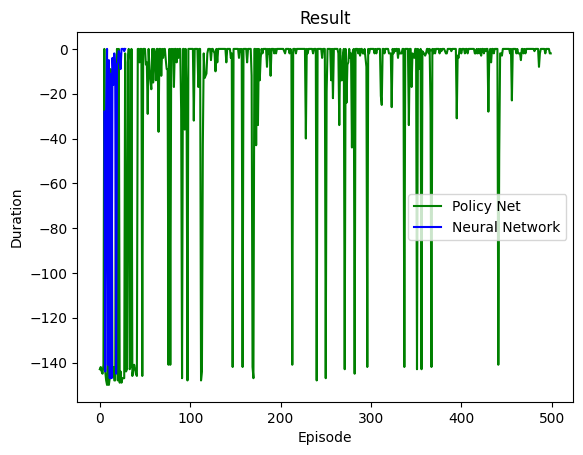

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [82]:
for i_episode in range(500):

    #policy-net
    policy_rew = 0
    state = initial_states[i_episode]
    x,y = findLoc(initial_states[i_episode], np.array([0,1,0]))[0]


    for t in range(50):
        state2d  = getLoc(state,1)[0]
        state2d = torch.tensor(list(state2d), dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(state2d,False)
        next_state = makeMove(state, action.item())
        reward = getReward(next_state)
        policy_rew += reward
        reward = torch.tensor([reward], device=device)
        next_state2d = getLoc(next_state,1)[0]
        next_state2d = torch.tensor(list(next_state2d), dtype=torch.float32, device=device).unsqueeze(0)
        if(not uncertainity_period):
            memory.push(state2d, action, next_state2d, reward)
        neural_data.append((state2d,action.item()))
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if ((reward == 100) and (after_uncertainity == False)):
            uncertainity_period = True
            if First_trained == -1 :
                First_trained = i_episode
            train_nn()



        if ((reward == 100) or (t==49)):
            neural_data.clear()
            difference = policy_rew - correct_rewards[x,y]
            episode_durations.append(difference)
            if(eps_policy>0.04):
              eps_policy -= (1/25)
            break



    if(uncertainity_period):
        neural_data.clear()
        nn_rew = 0
        state_n  = initial_states[i_episode]
        for t in range(50):
          state_n2d = getLoc(state_n,1)[0]
          state_n2d = torch.tensor(list(state_n2d), dtype=torch.float32, device=device).unsqueeze(0)
          action = select_action(state_n2d,True)
          next_state = makeMove(state_n, action.item())
          reward = getReward(next_state)
          nn_rew += reward
          reward = torch.tensor([reward], device=device)
          next_state2d = getLoc(next_state,1)[0]
          next_state2d = torch.tensor(list(next_state2d), dtype=torch.float32, device=device).unsqueeze(0)
          memory.push(state_n2d, action, next_state2d, reward)
          neural_data.append((state_n2d,action.item()))
          state_n = next_state

          if ((reward == 100)):
              train_nn()

          if ((reward == 100) or (t==49)):
              neural_data.clear()
              if(eps_nn>0.04):
                eps_nn -= (1/25)
              difference = nn_rew - correct_rewards[x,y]
              episode_durations2.append(difference)
              break
    plot_durations()



print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [83]:
for i in range(11, len(episode_durations)):
    window = episode_durations[i-10:i]
    all_less_than_or_equal_to_10 = all(duration >= -10 for duration in window)
    if all_less_than_or_equal_to_10:
        print(i)
        break

129


In [84]:
file_path = str(seed) + "_NN.txt"
with open(file_path, "w") as file:
    for index, item in enumerate(episode_durations):
        file.write(f"{index},{item}\n")